In [1]:
from sentence_transformers import (
    SentenceTransformer,
    InputExample,
    losses,
    SentenceTransformerTrainingArguments,
    SentenceTransformerTrainer,
)

from sentence_transformers.evaluation import (
    BinaryClassificationEvaluator,
    SimilarityFunction,
)

from transformers import AutoConfig, AutoTokenizer, AutoModel

from torch import nn
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import wandb

In [3]:
model_id = "intfloat/e5-base-v2"

# configuration = AutoConfig.from_pretrained(model_id)
# configuration.hidden_dropout_prob = 0.5
# configuration.attention_probs_dropout_prob = 0.5

# tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModel.from_pretrained(model_id, config=configuration)

model = SentenceTransformer(model_id)

In [35]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [36]:
model[0].auto_model.embeddings.dropout.p = 0.5

In [37]:
df = pd.read_csv("data/train.csv")

In [38]:
df.head()

,id,question1,question2,target
0,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
1,1,What are some tips on making it through the jo...,What are some tips on making it through the jo...,0
2,2,Why do some people think Obama will try to tak...,Has there been a gun control initiative to tak...,0
3,3,Why does China block sanctions at the UN again...,Why does China support Masood Azhar?,1
4,4,What is the ideal life after retirement?,What's life after retirement?,0


In [39]:
print(len(df))

26368


In [40]:
df['target'].value_counts()

target
0    17742
1     8626
Name: count, dtype: int64

In [5]:
dataset = load_dataset("csv", data_files="../data/train.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
dataset = dataset.remove_columns('id')
dataset = dataset.rename_column('question1', 'text1')
dataset = dataset.rename_column('question2', 'text2')
dataset = dataset.rename_column('target', 'label')

In [7]:
def prepend_query(example):
    example['text1'] = "query: " + example['text1']
    example['text2'] = "query: " + example['text2']
    return example

dataset = dataset.map(prepend_query)

Map:   0%|          | 0/26368 [00:00<?, ? examples/s]

In [8]:
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

In [9]:
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

In [10]:
loss = losses.CosineSimilarityLoss(
    model,
    cos_score_transformation=nn.ReLU()
)

In [11]:
batch_size=64
run_name = 'run_4'
output_dir = 'e5-base_' + run_name
num_epochs=10
checkpoint_path=False

In [55]:
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir=output_dir,
    # Optional training parameters:
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=5e-5,
    warmup_ratio=0.05,
    fp16=False,
    bf16=False,
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=100,
    logging_dir="./logs",
    run_name=run_name,
    report_to="wandb",
)

In [56]:
dev_evaluator = BinaryClassificationEvaluator(
    sentences1=test_dataset["text1"],
    sentences2=test_dataset["text2"],
    labels=test_dataset["label"],
    similarity_fn_names=['cosine'],
    batch_size=batch_size,
)

In [57]:
wandb.finish()

wandb_run_name = f"e5-base-v2-{run_name}_epochs-{num_epochs}"
wandb.init(
    project="DuplicateSearch",
    name=wandb_run_name,
    mode='offline',
    
)

In [58]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss=loss,
    evaluator=dev_evaluator,
)

trainer.train(resume_from_checkpoint=checkpoint_path)

Detected kernel version 5.3.18, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,Cosine Accuracy,Cosine Accuracy Threshold,Cosine F1,Cosine F1 Threshold,Cosine Precision,Cosine Recall,Cosine Ap,Cosine Mcc
100,0.285700,0.171640,0.824611,0.729708,0.756266,0.607420,0.656989,0.890889,0.805377,0.620927
200,0.138200,0.138890,0.849640,0.705429,0.783087,0.586238,0.705273,0.880202,0.820351,0.663717
300,0.125200,0.132823,0.856845,0.679287,0.797826,0.628110,0.739089,0.866704,0.832698,0.687544
400,0.111400,0.125806,0.856086,0.649449,0.796851,0.572616,0.726389,0.882452,0.831706,0.685803
500,0.110000,0.126283,0.864619,0.685149,0.812821,0.617722,0.746937,0.891451,0.849261,0.711299
600,0.099700,0.123238,0.870876,0.706742,0.816702,0.653225,0.766010,0.874578,0.855013,0.717689
700,0.093500,0.114267,0.868411,0.687701,0.808499,0.607845,0.765979,0.856018,0.854972,0.705337
800,0.082800,0.114123,0.875616,0.696727,0.818331,0.662240,0.794492,0.843645,0.858846,0.722454
900,0.081900,0.115375,0.876754,0.703381,0.822664,0.685631,0.797676,0.849269,0.862738,0.728984
1000,0.081200,0.112147,0.880925,0.712205,0.826871,0.671321,0.803609,0.851519,0.869129,0.735641


TrainOutput(global_step=3300, training_loss=0.06392761685631491, metrics={'train_runtime': 1064.0133, 'train_samples_per_second': 198.249, 'train_steps_per_second': 3.101, 'total_flos': 0.0, 'train_loss': 0.06392761685631491, 'epoch': 10.0})

In [59]:
wandb.finish()

eval/cosine_accuracy,▁▄▅▅▆▇▆▇▇█▇██▇▇█▇▇█▇▇▇██▇▇▇▇▇▇▇▇▇
eval/cosine_accuracy_threshold,▆▄▃▁▃▄▃▄▄▅▃▅▄▃▇▃▃▄▆█▆▄▆▅▆▅▅▃▅▇▇▅▆
eval/cosine_ap,▁▃▄▄▅▆▆▆▇█▇█████▇███████▇██▇█████
eval/cosine_f1,▁▄▅▅▇▇▆▇██▇▇█▇█▇▇▇▇▇▇▇██▇▇▇▇▇▇▇▇▇
eval/cosine_f1_threshold,▃▂▄▁▃▅▃▅▆▆▅▇▆▅▄▅▄▄▅▅▇▅▅▅▅▆▄▅▇▅▅██
eval/cosine_mcc,▁▄▅▅▇▇▆▇██▇██▇▇█▇▇█▇▇▇██▇▇▇▇▇▇▇▇▇
eval/cosine_precision,▁▃▅▄▅▆▆▇▇█▇██▇▆█▇▇▇▇█▇▇▇▇▇▇▇█▇▇██
eval/cosine_recall,█▇▆▇█▆▄▃▄▄▄▂▄▄▇▃▃▅▃▄▃▄▄▄▄▃▄▄▁▄▄▁▁
eval/loss,█▄▄▃▃▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▁▁▁▁▂▁▁▁▁▆▂▁▁▁▁▁▁▁▃▁▁▁▆▅▁▁▁▁▁▁▁▁
eval/samples_per_second,▁████▇████▃▇█████▇█▆███▃▄████████


## Test model

In [26]:
model = SentenceTransformer("e5-base_run_4/checkpoint-1700")

In [27]:
def test_model(model, test_dataset, clip_negative=True):
    sentences1=test_dataset['text1']
    sentences2=test_dataset["text2"]
    labels=test_dataset["label"]

    sentences = sentences1 + sentences2
    embeddings = model.encode(
        sentences,
        normalize_embeddings=True,
        show_progress_bar=True,
        convert_to_numpy=True,
    )
    
    embeddings1 = embeddings[: len(sentences1)]
    embeddings2 = embeddings[len(sentences1) :]

    similarity = 1 - paired_cosine_distances(embeddings1, embeddings2)
    if clip_negative:
        similarity[similarity < 0] = 0.0
    return similarity

In [28]:
similarity = test_model(model, test_dataset)

Batches:   0%|          | 0/330 [00:00<?, ?it/s]

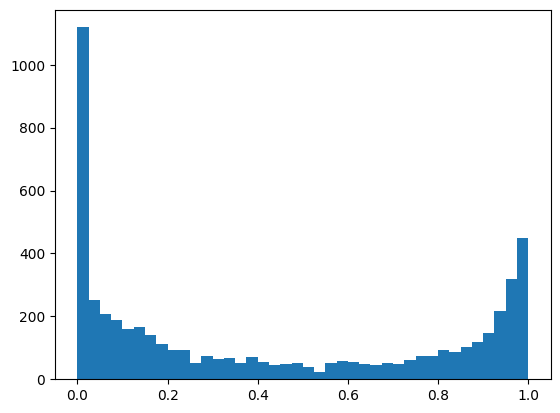

In [29]:
plt.hist(similarity, bins=40)
plt.show()

In [30]:
rocauc = roc_auc_score(test_dataset['label'], similarity)
print(f'ROC AUC: {rocauc}')

ROC AUC: 0.9309865300018276
